In [106]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import hiive.mdptoolbox
import hiive.mdptoolbox.mdp
import hiive.mdptoolbox.example
import mdptoolbox, mdptoolbox.example
import gym
import matplotlib.pyplot as plt
import time

In [107]:
def plot_simple_data(x_var, y_var, x_label, y_label, title, figure_size=(4,3)):
    plt.rcParams["figure.figsize"] = figure_size
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.plot(x_var, y_var)
    plt.show()
    plt.close()

def plot_data_legend(x_vars, x_label, all_y_vars, y_var_labels, y_label, title, y_bounds=None):
    colors = ['red','orange','black','green','blue','violet']
    plt.rcParams["figure.figsize"] = (4,3)

    i = 0
    for y_var in all_y_vars:
#         if i == 2: # don't plot when i = 1 for cv
#             x_vars = x_vars[1:]
        plt.plot(x_vars, y_var, 'o-', color=colors[i % 6], label=y_var_labels[i])
        i += 1
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if y_bounds != None:
        plt.ylim(y_bounds)
    leg = plt.legend()
    plt.show()



def make_time_array(run_stats, variables):
    cumulative_sum = 0
    times = []
    output_dict = {v:[] for v in variables}
    output_dict["times"] = times
    for result in run_stats:
        times.append(result["Time"])
        for v in result:
            if v in variables:
                output_dict[v].append(result[v])
    return output_dict

def compose_discounts(significant_digits):
    prev_discount = 0
    discounts = []
    for i in range(1,significant_digits + 1):
        discounts.append(round(prev_discount + 9*(10**-i),i))
        prev_discount = discounts[-1]
    return discounts

def run_forest(solver, states, discounts, epsilons, probability=0.1, max_iter=10):
    experiments = [] #num states, probability, discount, time, iterations, policy
    for s in states:
        for e in epsilons:
            for d in discounts:
                entry = {}
                P, R = hiive.mdptoolbox.example.forest(S=s, p=probability)
                #start_time = time.time()
                args = {"transitions":P, "reward":R, "gamma":d, "epsilon":e, "max_iter":max_iter, "skip_check":True}
                mdp = solver(args)
                mdp.run()
                #end_time = time.time()
                entry["time"] = mdp.time
                entry["iterations"] = mdp.iter
                entry["policy"] = mdp.policy
                entry["num_states"] = s
                entry["probability"] = probability
                entry["discount"] = d
                entry["epsilon"] = e
                entry["run_stats"] = mdp.run_stats
                experiments.append(entry)
    return experiments

def print_training_results(results):
    for result in fm_value_iteration_results:
        print("\nNew result #################")
        for key in result:
            if key != "policy":
                print("{0}: {1}".format(key,result[key]))

def collect_training_results(results, keys, to_print=True):
    output_dict = {key:[] for key in keys}
    for result in results:
        if to_print: print("\nNew result #################")
        for key in result:
            if key in keys:
                if to_print: print("{0}: {1}".format(key,result[key]))
                output_dict[key].append(result[key])
    return output_dict

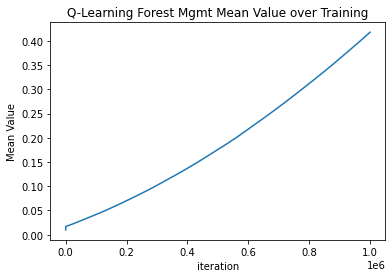

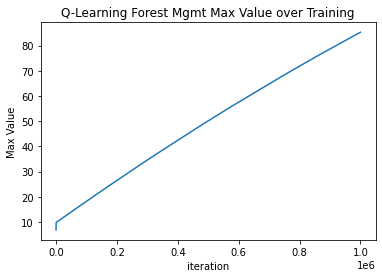

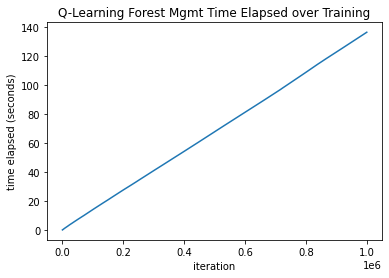

In [108]:


P, R = hiive.mdptoolbox.example.forest(S=2000, p=0.1)
st = time.time()
fm_q_mdp = hiive.mdptoolbox.mdp.QLearning(P, R, 0.999, epsilon=0.1,epsilon_decay=0.95, n_iter=1000000, alpha=0.90, skip_check=True)
fm_q_mdp.run()
end = time.time()
end-st
fm_q_mdp.policy

fm_q_curated_results = make_time_array(fm_q_mdp.run_stats, ["Mean V", "Max V", "Iteration"])
num_iters = len(fm_q_curated_results["Mean V"])
plot_simple_data(fm_q_curated_results["Iteration"], fm_q_curated_results["Mean V"],
                 "iteration", "Mean Value", "Q-Learning Forest Mgmt Mean Value over Training", figure_size=(6,4))
plot_simple_data(fm_q_curated_results["Iteration"], fm_q_curated_results["Max V"],
                 "iteration", "Max Value", "Q-Learning Forest Mgmt Max Value over Training", figure_size=(6,4))
plot_simple_data(fm_q_curated_results["Iteration"], fm_q_curated_results["times"],
                 "iteration", "time elapsed (seconds)", "Q-Learning Forest Mgmt Time Elapsed over Training", figure_size=(6,4))



In [109]:
print(fm_q_mdp.run_stats[0])
print(fm_q_mdp.run_stats[-1])

{'State': 466, 'Action': 0, 'Reward': 0.0, 'Error': 0.0, 'Time': 0.012527704238891602, 'Alpha': 0.33275667388475383, 'Epsilon': 0.1, 'Gamma': 0.999, 'Max V': 6.84504076780571, 'Mean V': 0.009828935840869905, 'Iteration': 100}
{'State': 1821, 'Action': 1, 'Reward': 1.0, 'Error': 0.08535206603647034, 'Time': 136.41749691963196, 'Alpha': 0.001, 'Epsilon': 0.1, 'Gamma': 0.999, 'Max V': 85.26776835721333, 'Mean V': 0.4180343573495861, 'Iteration': 1000000}


###This section is playing with hyper paramters for our Q Learner - alpha

On Alpha: 0.5
On Alpha: 0.6
On Alpha: 0.7
On Alpha: 0.8
On Alpha: 0.9
On Alpha: 0.999


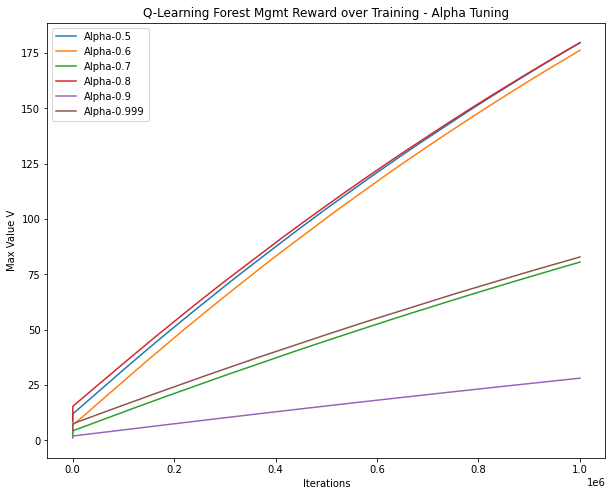

In [110]:
alphas = [.5,.6,.7,.8,.9,.999]
alpha_results = []

plt.rcParams["figure.figsize"] = (10,8)
alpha_v_fig = plt.figure()
plt.xlabel("Iterations")
plt.ylabel("Max Value V")
plt.title("Q-Learning Forest Mgmt Reward over Training - Alpha Tuning")

for alpha in alphas:
    print(f"On Alpha: {alpha}")
    alpha_run = hiive.mdptoolbox.mdp.QLearning(P, R, .999, epsilon=0.1,epsilon_decay=0.95, n_iter=1000000, alpha=alpha, skip_check=True)
    alpha_run.run()
    alpha_result = make_time_array(alpha_run.run_stats, ["Reward", "Mean V", "Max V", "Iteration", "Time"])
    alpha_results.append(alpha_result)
    plt.plot(alpha_result["Iteration"], alpha_result["Max V"], label=f"Alpha-{alpha}")

plt.legend(loc='best')
plt.show()
plt.close()


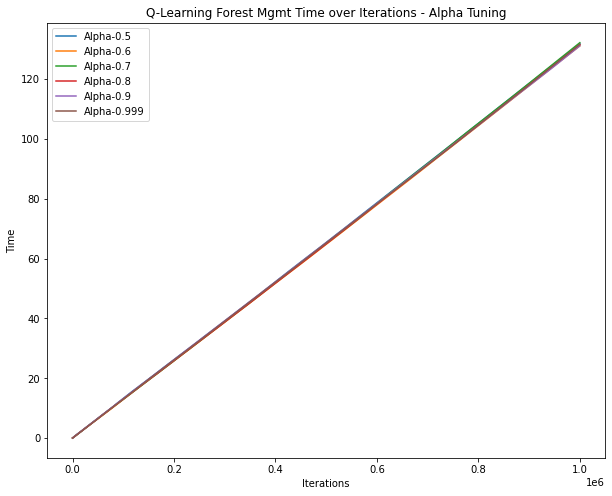

In [111]:
alpha_time_fig = plt.figure(figsize=(10,8))
plt.xlabel("Iterations")
plt.ylabel("Time")
plt.title("Q-Learning Forest Mgmt Time over Iterations - Alpha Tuning")
for i, result in enumerate(alpha_results):
    plt.plot(result["Iteration"], result["Time"], label=f"Alpha-{alphas[i]}")
plt.legend(loc='best')
plt.show()
plt.close()

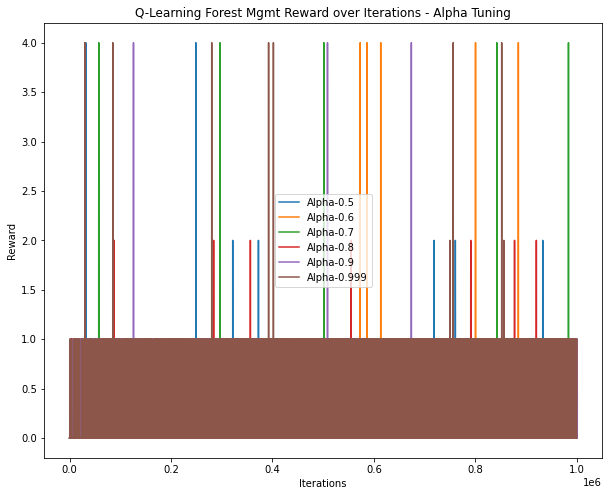

In [112]:
alpha_time_fig = plt.figure(figsize=(10,8))
plt.xlabel("Iterations")
plt.ylabel("Reward")
plt.title("Q-Learning Forest Mgmt Reward over Iterations - Alpha Tuning")
for i, result in enumerate(alpha_results):
    plt.plot(alpha_results[i]["Iteration"], alpha_results[i]["Reward"], label=f"Alpha-{alphas[i]}")
plt.legend(loc='best')
plt.show()
plt.close()

In [113]:
best_alpha = .9

Done Alpha

Start Gamma

On gamma: 0.5
On gamma: 0.6
On gamma: 0.7
On gamma: 0.8
On gamma: 0.9
On gamma: 0.95
On gamma: 0.99


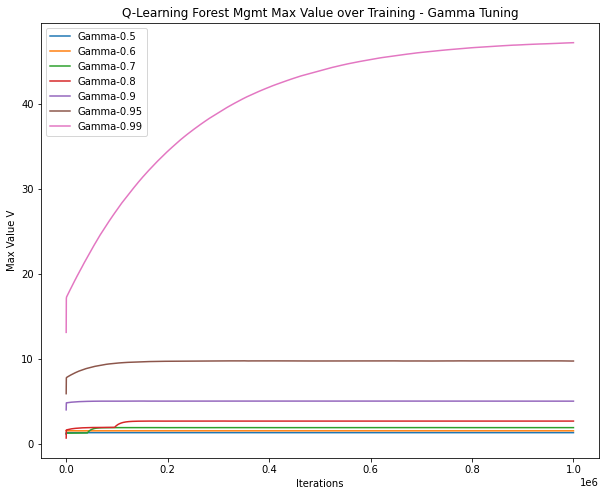

In [114]:

gammas = [.5,.6,.7,.8,.9,.95,.99]
gamma_results = []

gamma_v_fig = plt.figure(figsize=(10,8))
plt.xlabel("Iterations")
plt.ylabel("Max Value V")
plt.title("Q-Learning Forest Mgmt Max Value over Training - Gamma Tuning")

for gamma in gammas:
    print(f"On gamma: {gamma}")
    gamma_run = hiive.mdptoolbox.mdp.QLearning(P, R, gamma, epsilon=0.1,epsilon_decay=0.95, n_iter=1000000, alpha=best_alpha, skip_check=True)
    gamma_run.run()
    gamma_result = make_time_array(gamma_run.run_stats, ["Reward", "Mean V", "Max V", "Iteration", "Time"])
    gamma_results.append(gamma_result)
    plt.plot(gamma_result["Iteration"], gamma_result["Max V"], label=f"Gamma-{gamma}")

plt.legend(loc='best')
plt.show()
plt.close()


In [115]:
best_gamma = .999

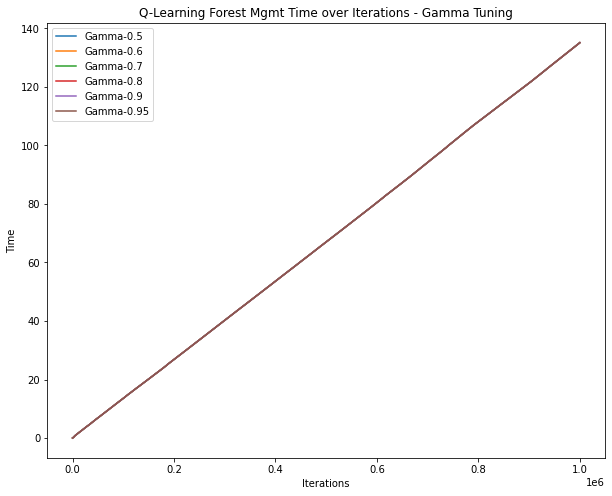

In [116]:
gamma_time_fig = plt.figure(figsize=(10,8))
plt.xlabel("Iterations")
plt.ylabel("Time")
plt.title("Q-Learning Forest Mgmt Time over Iterations - Gamma Tuning")

for i, result in enumerate(gamma_result):
    plt.plot(gamma_result["Iteration"], gamma_result["Time"], label=f"Gamma-{gammas[i]}")

plt.legend(loc='best')
plt.show()
plt.close()

End Gamma

Start Epsilon

On epsilon: 0.1 w/ decay - 0.3
On epsilon: 0.1 w/ decay - 0.5
On epsilon: 0.1 w/ decay - 0.7
On epsilon: 0.1 w/ decay - 0.9
On epsilon: 0.3 w/ decay - 0.3
On epsilon: 0.3 w/ decay - 0.5
On epsilon: 0.3 w/ decay - 0.7
On epsilon: 0.3 w/ decay - 0.9
On epsilon: 0.5 w/ decay - 0.3
On epsilon: 0.5 w/ decay - 0.5
On epsilon: 0.5 w/ decay - 0.7
On epsilon: 0.5 w/ decay - 0.9
On epsilon: 0.7 w/ decay - 0.3
On epsilon: 0.7 w/ decay - 0.5
On epsilon: 0.7 w/ decay - 0.7
On epsilon: 0.7 w/ decay - 0.9


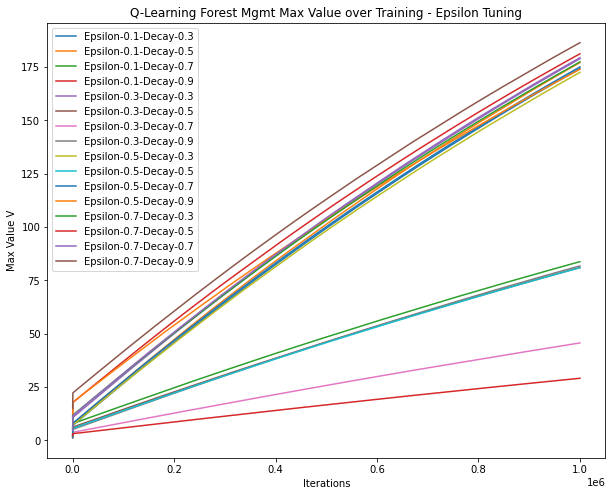

In [117]:

epsilons = [.1,.3,.5,.7]
epsilon_decays = [.3,.5,.7,.9]
epsilon_results = []


eps_v_fig = plt.figure(figsize=(10,8))
plt.xlabel("Iterations")
plt.ylabel("Max Value V")
plt.title("Q-Learning Forest Mgmt Max Value over Training - Epsilon Tuning")


for epsilon in epsilons:
    for decay in epsilon_decays:
        print(f"On epsilon: {epsilon} w/ decay - {decay}")
        epsilon_run = hiive.mdptoolbox.mdp.QLearning(P, R, best_gamma, epsilon=epsilon,epsilon_decay=decay, n_iter=1000000, alpha=best_alpha, skip_check=True)
        epsilon_run.run()
        epsilon_result = make_time_array(epsilon_run.run_stats, ["Reward", "Mean V", "Max V", "Iteration", "Time"])
        epsilon_results.append(epsilon_result)
        plt.plot(epsilon_result["Iteration"], epsilon_result["Max V"], label=f"Epsilon-{epsilon}-Decay-{decay}")

plt.legend(loc='best')
plt.show()
plt.close()




on epsilon: 0.1, decay: 0.3
on epsilon: 0.1, decay: 0.5
on epsilon: 0.1, decay: 0.7
on epsilon: 0.1, decay: 0.9
on epsilon: 0.3, decay: 0.3
on epsilon: 0.3, decay: 0.5
on epsilon: 0.3, decay: 0.7
on epsilon: 0.3, decay: 0.9
on epsilon: 0.5, decay: 0.3
on epsilon: 0.5, decay: 0.5
on epsilon: 0.5, decay: 0.7
on epsilon: 0.5, decay: 0.9
on epsilon: 0.7, decay: 0.3
on epsilon: 0.7, decay: 0.5
on epsilon: 0.7, decay: 0.7
on epsilon: 0.7, decay: 0.9


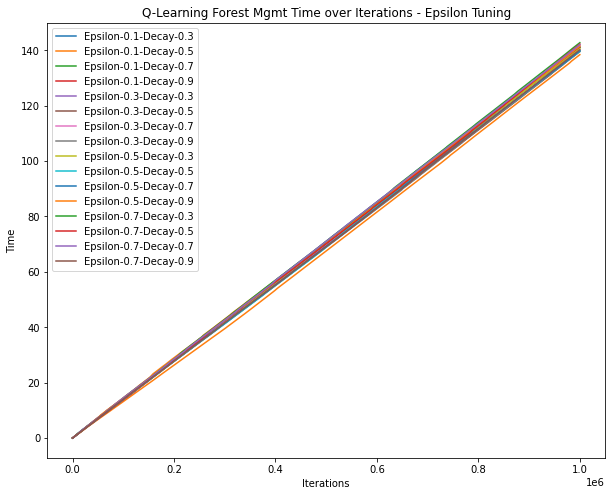

In [118]:
eps_time_fig = plt.figure(figsize=(10,8))
plt.xlabel("Iterations")
plt.ylabel("Time")
plt.title("Q-Learning Forest Mgmt Time over Iterations - Epsilon Tuning")
count = 0
for epsilon in epsilons:
    for decay in epsilon_decays:
        print(f"on epsilon: {epsilon}, decay: {decay}")
        plt.plot(epsilon_results[count]["Iteration"], epsilon_results[count]["Time"], label=f"Epsilon-{epsilon}-Decay-{decay}")
        count+=1
plt.legend(loc='best')
plt.show()
plt.close()

In [139]:
best_epsilon = .3
best_decay = .5

End Epsilon

Best Q Learner Begin

In [152]:
best_q_run = hiive.mdptoolbox.mdp.QLearning(P, R, best_gamma, epsilon=best_epsilon,epsilon_decay=best_decay, n_iter=1000000, alpha=best_alpha, skip_check=True)
best_q_run.run()

[{'State': 1113,
  'Action': 1,
  'Reward': 1.0,
  'Error': 2.0693235109258263,
  'Time': 0.016492843627929688,
  'Alpha': 0.33275667388475383,
  'Epsilon': 0.1,
  'Gamma': 0.999,
  'Max V': 5.624775484118209,
  'Mean V': 0.008532097383585463,
  'Iteration': 100},
 {'State': 1383,
  'Action': 1,
  'Reward': 1.0,
  'Error': 1.3375210895042355,
  'Time': 0.03003668785095215,
  'Alpha': 0.12179970441632886,
  'Epsilon': 0.1,
  'Gamma': 0.999,
  'Max V': 10.503546459467481,
  'Mean V': 0.016885052660406595,
  'Iteration': 200},
 {'State': 289,
  'Action': 0,
  'Reward': 0.0,
  'Error': 0.0,
  'Time': 0.04142117500305176,
  'Alpha': 0.04458263097389609,
  'Epsilon': 0.1,
  'Gamma': 0.999,
  'Max V': 12.105838996382907,
  'Mean V': 0.019182695871983776,
  'Iteration': 300},
 {'State': 1672,
  'Action': 1,
  'Reward': 1.0,
  'Error': 0.21347634759439052,
  'Time': 0.05392265319824219,
  'Alpha': 0.016318684795495572,
  'Epsilon': 0.1,
  'Gamma': 0.999,
  'Max V': 12.582001454628633,
  'Mean V

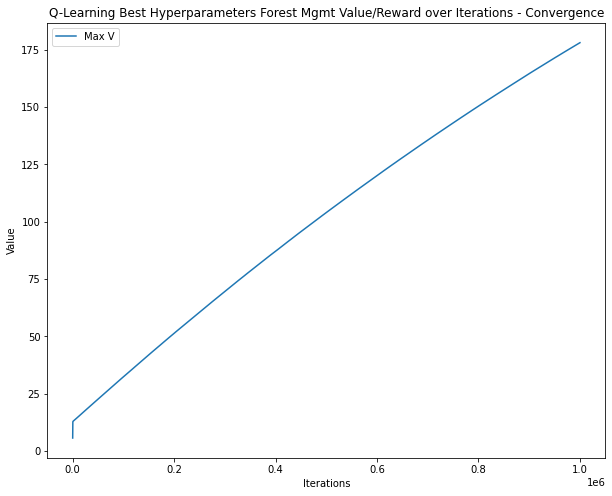

In [153]:
best_q_results = make_time_array(best_q_run.run_stats, ["Reward", "Mean V", "Max V", "Iteration", "Time"])

best_q_fig = plt.figure(figsize=(10,8))
plt.xlabel("Iterations")
plt.ylabel("Value")
plt.title("Q-Learning Best Hyperparameters Forest Mgmt Value/Reward over Iterations - Convergence")
plt.plot(best_q_results["Iteration"], best_q_results["Max V"], label="Max V")
# plt.plot(best_q_results["Iteration"], best_q_results["Mean V"], label="Mean V")
# plt.plot(best_q_results["Iteration"], best_q_results["Reward"], label="Reward")
plt.legend(loc='best')
plt.show()
plt.close()

Best Q Learner End

Value Iteration Begin

Epsilon Tuning

On epsilon: 0.1
On epsilon: 0.3
On epsilon: 0.5
On epsilon: 0.7


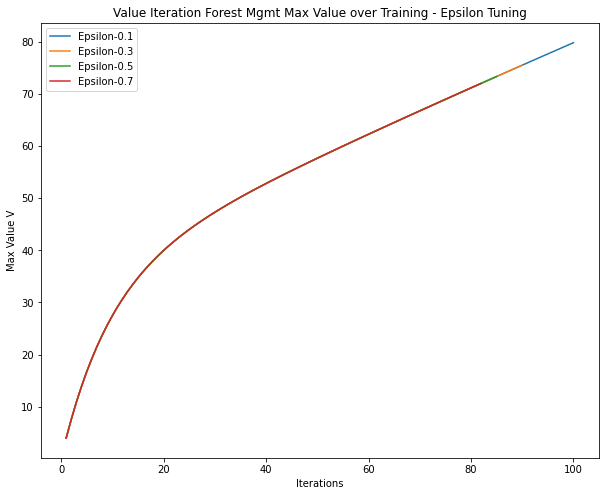

In [122]:

epsilons = [.1,.3,.5,.7]
value_epsilon_results_val = []


value_eps_v_fig = plt.figure(figsize=(10,8))
plt.xlabel("Iterations")
plt.ylabel("Max Value V")
plt.title("Value Iteration Forest Mgmt Max Value over Training - Epsilon Tuning")


for epsilon in epsilons:
    print(f"On epsilon: {epsilon}")
    epsilon_run = hiive.mdptoolbox.mdp.ValueIteration(P, R, best_gamma, epsilon=epsilon, skip_check=True)
    epsilon_run.run()
    epsilon_result = make_time_array(epsilon_run.run_stats, ["Reward", "Mean V", "Max V", "Iteration", "Time"])
    value_epsilon_results_val.append(epsilon_result)
    plt.plot(epsilon_result["Iteration"], epsilon_result["Max V"], label=f"Epsilon-{epsilon}")

plt.legend(loc='best')
plt.show()
plt.close()

on epsilon: 0.1
on epsilon: 0.3
on epsilon: 0.5
on epsilon: 0.7


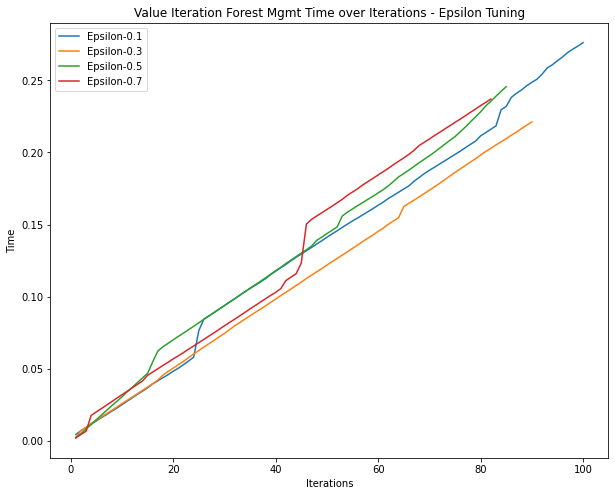

In [123]:
value_eps_time_fig = plt.figure(figsize=(10,8))
plt.xlabel("Iterations")
plt.ylabel("Time")
plt.title("Value Iteration Forest Mgmt Time over Iterations - Epsilon Tuning")
count = 0
for epsilon in epsilons:
    print(f"on epsilon: {epsilon}")
    plt.plot(value_epsilon_results_val[count]["Iteration"], value_epsilon_results_val[count]["Time"], label=f"Epsilon-{epsilon}")
    count+=1
plt.legend(loc='best')
plt.show()
plt.close()

In [124]:
value_best_epsilon = .1

End Epsilon Tuning - note did not matter

Begin Gamma Tuning

On gamma: 0.5
On gamma: 0.6
On gamma: 0.7
On gamma: 0.8
On gamma: 0.9
On gamma: 0.95
On gamma: 0.99


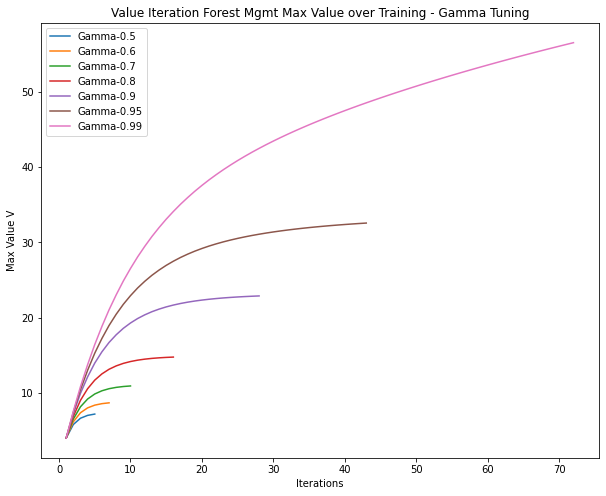

In [125]:

gammas = [.5,.6,.7,.8,.9,.95,.99]
gamma_value_results = []

gamma_value_fig = plt.figure(figsize=(10,8))
plt.xlabel("Iterations")
plt.ylabel("Max Value V")
plt.title("Value Iteration Forest Mgmt Max Value over Training - Gamma Tuning")

for gamma in gammas:
    print(f"On gamma: {gamma}")
    gamma_run = hiive.mdptoolbox.mdp.ValueIteration(P, R, gamma, epsilon=value_best_epsilon, skip_check=True)
    gamma_run.run()
    gamma_result = make_time_array(gamma_run.run_stats, ["Reward", "Mean V", "Max V", "Iteration", "Time"])
    gamma_value_results.append(gamma_result)
    plt.plot(gamma_result["Iteration"], gamma_result["Max V"], label=f"Gamma-{gamma}")

plt.legend(loc='best')
plt.show()
plt.close()


on gamma: 0.5
on gamma: 0.6
on gamma: 0.7
on gamma: 0.8
on gamma: 0.9
on gamma: 0.95
on gamma: 0.99


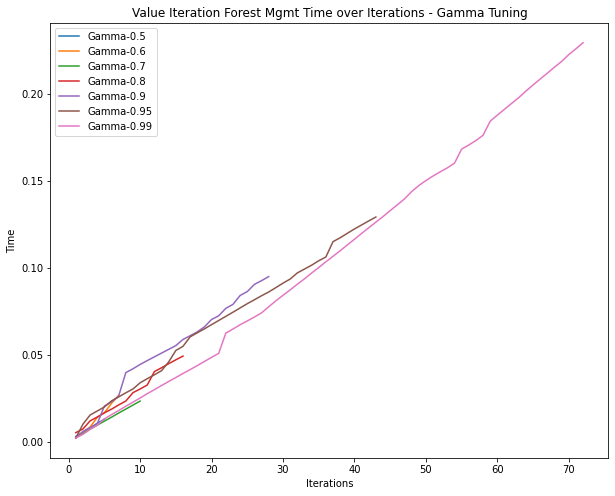

In [126]:
value_gamma_time_fig = plt.figure(figsize=(10,8))
plt.xlabel("Iterations")
plt.ylabel("Time")
plt.title("Value Iteration Forest Mgmt Time over Iterations - Gamma Tuning")
count = 0
for gamma in gammas:
    print(f"on gamma: {gamma}")
    plt.plot(gamma_value_results[count]["Iteration"], gamma_value_results[count]["Time"], label=f"Gamma-{gamma}")
    count+=1
plt.legend(loc='best')
plt.show()
plt.close()

In [127]:
value_best_gamma = .9

End Gamma Tuning

Best Value Iteration

In [128]:
best_val_run = hiive.mdptoolbox.mdp.ValueIteration(P, R, value_best_gamma, epsilon=value_best_epsilon, max_iter=1000000, skip_check=True)
best_val_run.run()

[{'State': None,
  'Action': None,
  'Reward': 4.0,
  'Error': 4.0,
  'Time': 0.005269765853881836,
  'Max V': 4.0,
  'Mean V': 1.001,
  'Iteration': 1},
 {'State': None,
  'Action': None,
  'Reward': 7.24,
  'Error': 3.24,
  'Time': 0.007972002029418945,
  'Max V': 7.24,
  'Mean V': 1.004145,
  'Iteration': 2},
 {'State': None,
  'Action': None,
  'Reward': 9.9373,
  'Error': 2.6244,
  'Time': 0.01011347770690918,
  'Max V': 9.9373,
  'Mean V': 1.7352693999999995,
  'Iteration': 3},
 {'State': None,
  'Action': None,
  'Reward': 12.128674000000002,
  'Error': 2.1257640000000015,
  'Time': 0.013004064559936523,
  'Max V': 12.128674000000002,
  'Mean V': 1.8045685984999995,
  'Iteration': 4},
 {'State': None,
  'Action': None,
  'Reward': 13.957421530000001,
  'Error': 1.721868840000001,
  'Time': 0.01525568962097168,
  'Max V': 13.957421530000001,
  'Mean V': 2.3442820681549996,
  'Iteration': 5},
 {'State': None,
  'Action': None,
  'Reward': 15.448326111400002,
  'Error': 1.394713760

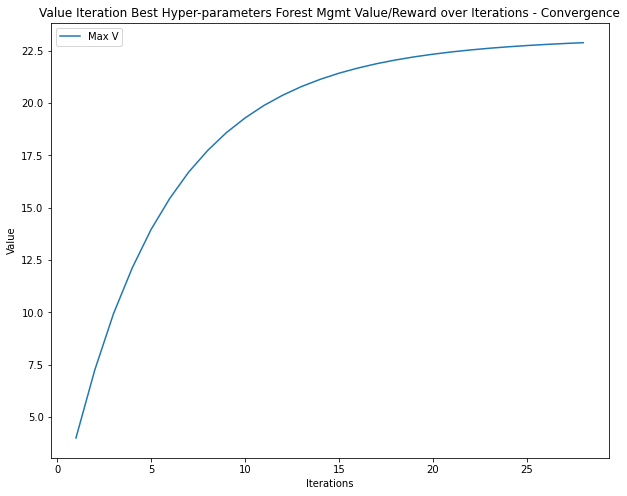

In [144]:
best_val_results = make_time_array(best_val_run.run_stats, ["Reward", "Mean V", "Max V", "Iteration", "Time"])

best_val_fig = plt.figure(figsize=(10,8))
plt.xlabel("Iterations")
plt.ylabel("Value")
plt.title("Value Iteration Best Hyper-parameters Forest Mgmt Value/Reward over Iterations - Convergence")
plt.plot(best_val_results["Iteration"], best_val_results["Reward"], label="Max V")
# plt.plot(best_val_results["Iteration"], best_val_results["Mean V"], label="Mean V")
# plt.plot(best_val_results["Iteration"], best_val_results["Reward"], label="Reward")
plt.legend(loc='best')
plt.show()
plt.close()

End Best Value Iteration

End Value Iteration

Begin Policy Iteration

Begin Gamma Tuning

On gamma: 0.5
On gamma: 0.7
On gamma: 0.9
On gamma: 0.99
On gamma: 0.999


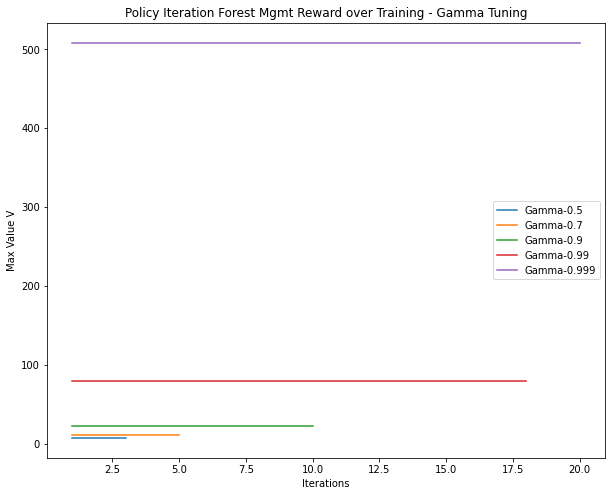

In [130]:
gammas = [.5,.7,.9,.99,.999]
policy_gamma_results_val = []

policy_eps_v_fig = plt.figure(figsize=(10,8))
plt.xlabel("Iterations")
plt.ylabel("Max Value V")
plt.title("Policy Iteration Forest Mgmt Reward over Training - Gamma Tuning")

for gamma in gammas:
    print(f"On gamma: {gamma}")
    epsilon_run = hiive.mdptoolbox.mdp.PolicyIteration(P, R, gamma, skip_check=True)
    epsilon_run.run()
    # print(f"{epsilon_run.run_stats}")
    epsilon_result = make_time_array(epsilon_run.run_stats, ["Reward", "Mean V", "Max V", "Iteration", "Time"])
    policy_gamma_results_val.append(epsilon_result)
    plt.plot(epsilon_result["Iteration"], epsilon_result["Reward"], label=f"Gamma-{gamma}")

plt.legend(loc='best')
plt.show()
plt.close()

on gamma: 0.5
on gamma: 0.7
on gamma: 0.9
on gamma: 0.99
on gamma: 0.999


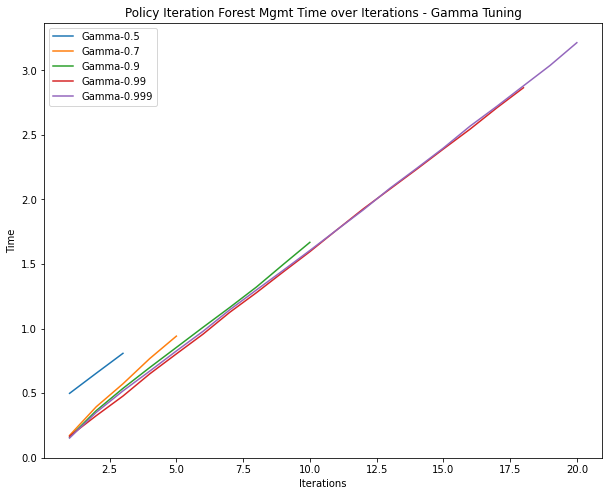

In [131]:
policy_eps_time_fig = plt.figure(figsize=(10,8))
plt.xlabel("Iterations")
plt.ylabel("Time")
plt.title("Policy Iteration Forest Mgmt Time over Iterations - Gamma Tuning")
count = 0
for gamma in gammas:
    print(f"on gamma: {gamma}")
    plt.plot(policy_gamma_results_val[count]["Iteration"], policy_gamma_results_val[count]["Time"], label=f"Gamma-{gamma}")
    count+=1
plt.legend(loc='best')
plt.show()
plt.close()

In [132]:
best_policy_gamma = .999

In [148]:
best_pol_run = hiive.mdptoolbox.mdp.PolicyIteration(P, R, best_policy_gamma, max_iter=1000000, skip_check=True)
best_pol_run.run()

[{'State': None,
  'Action': None,
  'Reward': 508.3858772182226,
  'Error': 30.424527105036134,
  'Time': 0.9076972007751465,
  'Max V': 508.3858772182226,
  'Mean V': 473.9782990941314,
  'Iteration': 1},
 {'State': None,
  'Action': None,
  'Reward': 508.3858772182225,
  'Error': 26.828127105035776,
  'Time': 2.169090986251831,
  'Max V': 508.3858772182225,
  'Mean V': 473.9935113576844,
  'Iteration': 2},
 {'State': None,
  'Action': None,
  'Reward': 508.3858772182225,
  'Error': 23.59460386503531,
  'Time': 3.7570648193359375,
  'Max V': 508.3858772182225,
  'Mean V': 474.00692542123716,
  'Iteration': 3},
 {'State': None,
  'Action': None,
  'Reward': 508.3858772182225,
  'Error': 20.687343119951322,
  'Time': 4.26305627822876,
  'Max V': 508.3858772182225,
  'Mean V': 474.01872272316973,
  'Iteration': 4},
 {'State': None,
  'Action': None,
  'Reward': 508.3858772182225,
  'Error': 18.07342498404637,
  'Time': 4.442213773727417,
  'Max V': 508.3858772182225,
  'Mean V': 474.029

In [149]:
best_pol_run.run_stats

[{'State': None,
  'Action': None,
  'Reward': 508.3858772182226,
  'Error': 30.424527105036134,
  'Time': 0.9076972007751465,
  'Max V': 508.3858772182226,
  'Mean V': 473.9782990941314,
  'Iteration': 1},
 {'State': None,
  'Action': None,
  'Reward': 508.3858772182225,
  'Error': 26.828127105035776,
  'Time': 2.169090986251831,
  'Max V': 508.3858772182225,
  'Mean V': 473.9935113576844,
  'Iteration': 2},
 {'State': None,
  'Action': None,
  'Reward': 508.3858772182225,
  'Error': 23.59460386503531,
  'Time': 3.7570648193359375,
  'Max V': 508.3858772182225,
  'Mean V': 474.00692542123716,
  'Iteration': 3},
 {'State': None,
  'Action': None,
  'Reward': 508.3858772182225,
  'Error': 20.687343119951322,
  'Time': 4.26305627822876,
  'Max V': 508.3858772182225,
  'Mean V': 474.01872272316973,
  'Iteration': 4},
 {'State': None,
  'Action': None,
  'Reward': 508.3858772182225,
  'Error': 18.07342498404637,
  'Time': 4.442213773727417,
  'Max V': 508.3858772182225,
  'Mean V': 474.029

End Policy Iteration

In [134]:
print("Policy Comparison")

print(f"Val policy {best_val_run.policy}")
print(f"Pol policy {best_pol_run.policy}")
print(f"Q Policy {best_q_run.policy}")


Policy Comparison
Val policy (0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

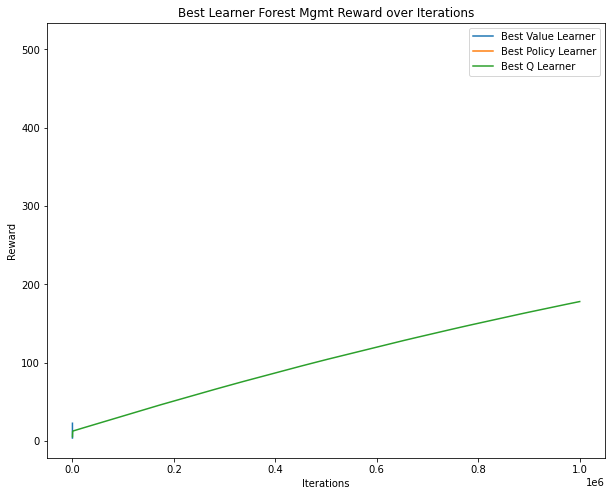

In [158]:
best_fig = plt.figure(figsize=(10,8))
plt.xlabel("Iterations")
plt.ylabel("Reward")
plt.title("Best Learner Forest Mgmt Reward over Iterations")

best_val_run_result = make_time_array(best_val_run.run_stats, ["Reward", "Mean V", "Max V", "Iteration", "Time"])
best_pol_run_results = make_time_array(best_pol_run.run_stats, ["Reward", "Mean V", "Max V", "Iteration", "Time"])
best_q_run_results = make_time_array(best_q_run.run_stats, ["Reward", "Mean V", "Max V", "Iteration", "Time"])
plt.plot(best_val_run_result["Iteration"], best_val_run_result["Max V"], label=f"Best Value Learner")
plt.plot(best_pol_run_results["Iteration"], best_pol_run_results["Max V"], label=f"Best Policy Learner")
plt.plot(best_q_run_results["Iteration"], best_q_run_results["Max V"], label=f"Best Q Learner")

# plt.ylim([0, 20])
plt.legend(loc='best')
plt.show()
plt.close()

In [135]:


states = [10**s for s in range(1,4)]
discounts = compose_discounts(3)
discounts = [0.999999,0.9999999]
epsilons = [0.01, 0.005, 0.001]

fm_policy_iteration = lambda dict_args: hiive.mdptoolbox.mdp.PolicyIterationModified(**dict_args)
fm_policy_iteration_results = run_forest(fm_policy_iteration, states, discounts, epsilons)



states = [10**s for s in range(2,4)]
discounts = compose_discounts(5)
epsilons = [0.01, 0.005, 0.001]


fm_value_iteration = lambda dict_args: hiive.mdptoolbox.mdp.ValueIteration(**dict_args)
fm_value_iteration_results = run_forest(fm_value_iteration, states, discounts, epsilons)

fm_value_iteration_results


[{'time': 0.00272369384765625,
  'iterations': 39,
  'policy': (0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0),
  'num_states': 100,
  'probability': 0.1,
  'discount': 0.9,
  'epsilon': 0.01,
  'run_stats': [{'State': None,
    'Action': None,
    'Reward': 4.0,
    'Error': 4.0,
    'Time': 5.1975250244140625e-05,
    'Max V': 4.0,
    'Mean V': 1.02,
    'Iteration': 1},
   {'State': None,
    'Action': None,
    'Reward': 7.24,
    'Error': 3

In [136]:
states = [k*10**pwr for pwr in range(2,3) for k in range(1,10)]
states += [1000]
states += [1000 + s for s in (states) ]

discounts = [0.9999999]
epsilons = [0.1]



New result #################
time: 0.021074533462524414
iterations: 188
num_states: 100
probability: 0.1
discount: 0.9999999
epsilon: 0.1
run_stats: [{'State': None, 'Action': None, 'Reward': 4.0, 'Error': 4.0, 'Time': 5.269050598144531e-05, 'Max V': 4.0, 'Mean V': 1.02, 'Iteration': 1}, {'State': None, 'Action': None, 'Reward': 7.59999964, 'Error': 3.59999964, 'Time': 0.00012993812561035156, 'Max V': 7.59999964, 'Mean V': 1.0909999918999997, 'Iteration': 2}, {'State': None, 'Action': None, 'Reward': 10.929998974000034, 'Error': 3.2399993520000328, 'Time': 0.0002052783966064453, 'Max V': 10.929998974000034, 'Mean V': 2.0457997989400094, 'Iteration': 3}, {'State': None, 'Action': None, 'Reward': 13.935998072200123, 'Error': 2.9159991252000883, 'Time': 0.000270843505859375, 'Max V': 13.935998072200123, 'Mean V': 2.2416297363810163, 'Iteration': 4}, {'State': None, 'Action': None, 'Reward': 16.72329695728029, 'Error': 2.624398950240159, 'Time': 0.00036716461181640625, 'Max V': 16.7232969

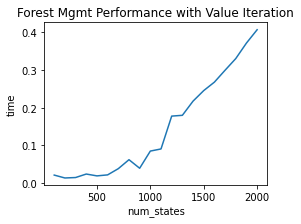

In [137]:


fm_value_iteration = lambda dict_args: hiive.mdptoolbox.mdp.ValueIteration(**dict_args)
fm_value_iteration_results = run_forest(fm_value_iteration, states, discounts, epsilons)
print_training_results(fm_value_iteration_results)
fm_vi_time_num_states = collect_training_results(fm_value_iteration_results, ["time", "num_states"], to_print=False)
fm_vi_iters_num_states = collect_training_results(fm_value_iteration_results, ["iterations", "num_states"], to_print=False)
plot_simple_data(fm_vi_time_num_states["num_states"], fm_vi_time_num_states["time"], "num_states", "time", "Forest Mgmt Performance with Value Iteration")



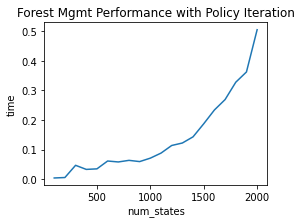

In [138]:
fm_policy_iteration = lambda dict_args: hiive.mdptoolbox.mdp.PolicyIterationModified(**dict_args)
fm_policy_iteration_results = run_forest(fm_policy_iteration, states, discounts, epsilons)
fm_pi_time_num_states = collect_training_results(fm_policy_iteration_results, ["time", "num_states"], to_print=False)
fm_pi_iters_num_states = collect_training_results(fm_policy_iteration_results, ["iterations", "num_states"], to_print=False)
plot_simple_data(fm_pi_time_num_states["num_states"], fm_pi_time_num_states["time"], "num_states", "time", "Forest Mgmt Performance with Policy Iteration")